In [1]:
import shutil, os
import cv2
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [4]:
!pip install patchify

In [6]:
!pip install keras

In [ ]:
!pip install segmentation-models

In [8]:
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
import splitfolders

In [16]:
path_img = 'rs19_val/jpgs/rs19_val/'
path_json = 'rs19_val/jsons/rs19_val/'
path_mask= 'rs19_val/uint8/rs19_val/'
tram_img= 'tram/jpgs/'
tram_json = 'tram/jsons/'
tram_mask= 'tram/uint8/'

In [36]:
tram_list= pd.read_csv('list_tram.csv',header=None)

In [38]:
tram_list.columns=['name']

In [39]:
tram=tram_list['name'].tolist()

In [59]:
for imgfile in range(len(tram)):
    img= cv2.imread(path_img+tram[imgfile][:7]+'.jpg')#read only tram images the images from rs19val directory
    cv2.imwrite(tram_img+tram[imgfile][:7]+'.jpg',img)

In [60]:
for maskfile in range(len(tram)):
    img_mask= cv2.imread(path_mask+tram[maskfile][:7]+'.png')#read only tram images the images from rs19val directory
    cv2.imwrite(tram_mask+tram[maskfile][:7]+'.png',img_mask)


In [62]:
for jsonfile in range(len(tram)):
    json = path_json + tram[jsonfile][:7] +'.json'
    shutil.copy(json, tram_json)

## Crop the images and patchify them to 256x256

In [ ]:
#Now, crop each large image into patches of 256x256. Save them into a directory 
#so we can use data augmentation and read directly from the drive. 
root_directory = 'tram/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
img_dir=root_directory+"jpgs/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    images_subset=images[0:100]
    #print(images)
    for i, image_name in enumerate(images_subset):  
        if image_name.endswith(".jpg"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".jpg", single_patch_img)
                    #image_dataset.append(single_patch_img)

## repeat from Masks 

In [54]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir=root_directory+"uint8/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    masks_subset=masks[0:100]
    for i, mask_name in enumerate(masks_subset):  
        if mask_name.endswith(".png"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            # change 255 to 19 label class
            #temp_mask[:,:,0][temp_mask[:,:,0]!=labels[cls]]=0 
            mask[:,:][mask[:,:]==255]=0
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)     

                 
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".png", single_patch_mask)

Now patchifying mask: tram/uint8//rs00001.png
Now patchifying mask: tram/uint8//rs00003.png
Now patchifying mask: tram/uint8//rs00006.png
Now patchifying mask: tram/uint8//rs00015.png
Now patchifying mask: tram/uint8//rs00023.png
Now patchifying mask: tram/uint8//rs00026.png
Now patchifying mask: tram/uint8//rs00031.png
Now patchifying mask: tram/uint8//rs00039.png
Now patchifying mask: tram/uint8//rs00041.png
Now patchifying mask: tram/uint8//rs00042.png
Now patchifying mask: tram/uint8//rs00055.png
Now patchifying mask: tram/uint8//rs00060.png
Now patchifying mask: tram/uint8//rs00061.png
Now patchifying mask: tram/uint8//rs00070.png
Now patchifying mask: tram/uint8//rs00079.png
Now patchifying mask: tram/uint8//rs00086.png
Now patchifying mask: tram/uint8//rs00087.png
Now patchifying mask: tram/uint8//rs00092.png
Now patchifying mask: tram/uint8//rs00095.png
Now patchifying mask: tram/uint8//rs00096.png
Now patchifying mask: tram/uint8//rs00097.png
Now patchifying mask: tram/uint8//

## sanity check after patching


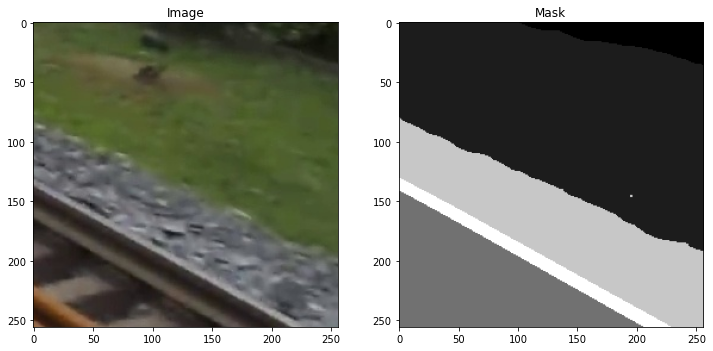

In [58]:
train_img_dir = "tram/256_patches/images/"
train_mask_dir = "tram/256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

# split the tram images to train and val

In [59]:
input_folder = 'tram/256_patches'
output_folder = 'tram/traintest2/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default value

Copying files: 5600 files [01:05, 86.12 files/s] 


# Train

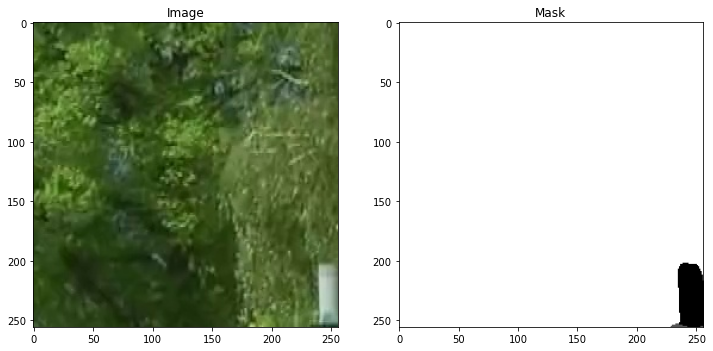

In [71]:
# Data Understanding

train_img_dir = "tram/split_data_for_keras_aug/train_images/train/"
train_mask_dir = "tram/split_data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [86]:
seed=24
batch_size= 4
n_classes=20

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

## Train the Generators with Preprocessed Models 
### Use this to preprocess input for transfer learning

In [74]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

## Preprocess

In [75]:
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

## Generator

In [89]:
#!pip install Keras-Preprocessing

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [77]:
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, ..... 18

def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    #flow_from_directory
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)# use same same for img and mask
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)# use same seed for img and masks
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask) # yield the preprocessed images from the train_generator images in batches of batch_size=4

In [78]:
train_img_path = "tram/split_data_for_keras_aug/train_images/"
train_mask_path = "tram/split_data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=20)

val_img_path = "tram/split_data_for_keras_aug/val_images/"
val_mask_path = "tram/split_data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=20)

### traverse through images generated by image generator to do sanity check for images and masks 

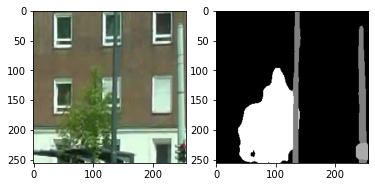

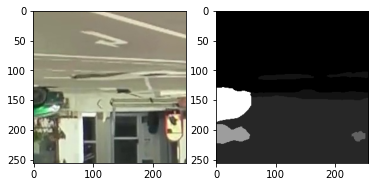

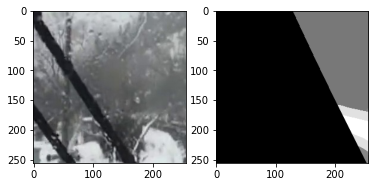

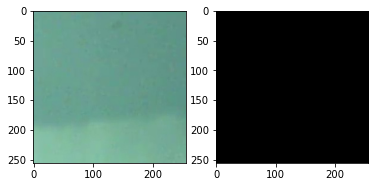

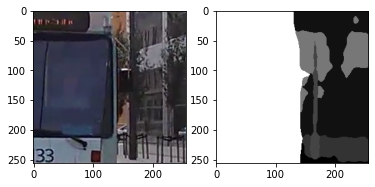

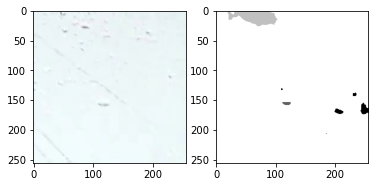

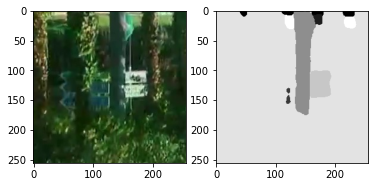

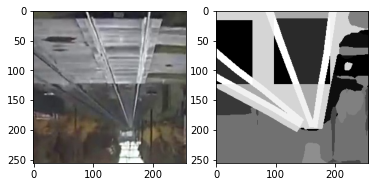

In [84]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

for i in range(0,4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,4):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

# Define the Model 

In [85]:
###########################################################################
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('tram/split_data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('tram/split_data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=19

# Using Pretrained U-net -> Transfer Learning

# U-Net Pretrained Encoder
## using Resnet34 as Backbone
## imagenet weights
### jaccard loss

### batch size 4

In [87]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

85521592/85521592 [==============================] - 8s 0us/step


In [88]:
print(model.summary())
print(model.input_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

# Fit the model and save it 

In [89]:
#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)




Epoch 1/25
420/420 [==============================] - 3457s 8s/step - loss: 0.9777 - iou_score: 0.0476 - val_loss: 1.0259 - val_iou_score: 0.0136
Epoch 2/25
420/420 [==============================] - 3168s 8s/step - loss: 0.9591 - iou_score: 0.0663 - val_loss: 1.0277 - val_iou_score: 0.0157
Epoch 3/25
420/420 [==============================] - 3371s 8s/step - loss: 0.9534 - iou_score: 0.0717 - val_loss: 0.9498 - val_iou_score: 0.0730
Epoch 4/25
420/420 [==============================] - 3374s 8s/step - loss: 0.9492 - iou_score: 0.0760 - val_loss: 0.9573 - val_iou_score: 0.0683
Epoch 5/25
420/420 [==============================] - 1979s 5s/step - loss: 0.9466 - iou_score: 0.0790 - val_loss: 0.9534 - val_iou_score: 0.0728
Epoch 6/25
420/420 [==============================] - 2786s 7s/step - loss: 0.9417 - iou_score: 0.0838 - val_loss: 0.9534 - val_iou_score: 0.0718
Epoch 7/25
420/420 [==============================] - 2757s 7s/step - loss: 0.9387 - iou_score: 0.0869 - val_loss: 0.9398 - 

In [90]:
model.save('1stmodel_25_epochs_RESNET_backbone_batch4.hdf5')

# plot the model IoU and loss for training and validation

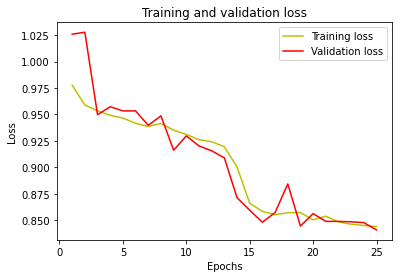

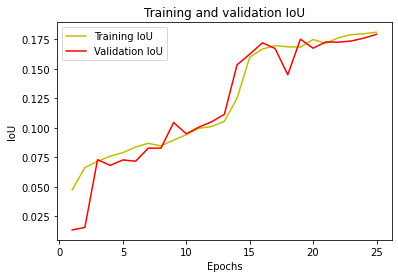

In [91]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# load the saved model

In [92]:
from keras.models import load_model

model = load_model("1stmodel_25_epochs_RESNET_backbone_batch4.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 20
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.17085782


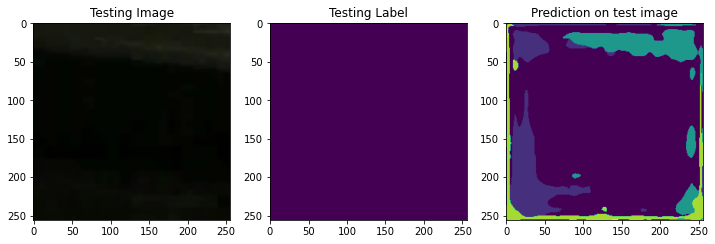

In [115]:
#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

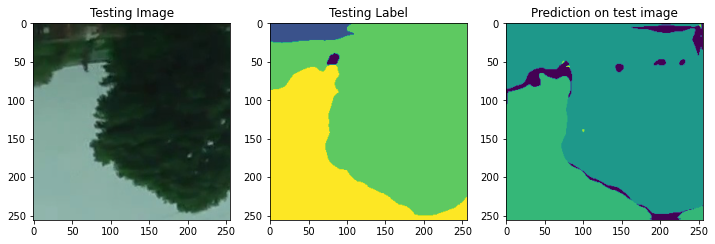

In [131]:
#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()